# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [16]:
#Imports needed

import numpy as np
import time
import json
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import tensor
import torchvision.models as models
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import argparse
from collections import OrderedDict
import PIL
import seaborn as sns
from PIL import Image

1.12.0+cu102


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
#Loading data with torchvision

data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
#Transform training set, and converting to tensor

train_transform =  transforms.Compose([
                   transforms.RandomResizedCrop(224),
                   transforms.RandomHorizontalFlip(),
                   transforms.ToTensor(),
                   transforms.Normalize([0.485, 0.456, 0.406], 
                                        [0.229, 0.224, 0.225])])

#Transform test set, and converting to tensor                   
                   
test_transform = transforms.Compose([
                 transforms.Resize(256),
                 transforms.CenterCrop(224),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], 
                                      [0.229, 0.224, 0.225])])

#Transform validation set, and converting to tensor                

validation_transform = transforms.Compose([
                  transforms.Resize(256),
                  transforms.CenterCrop(224),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485, 0.456, 0.406], 
                                       [0.229, 0.224, 0.225])])
    

#Loading the datasets with ImageFolder

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transform)
                            

#Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True)

    

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

<font color='red'>**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.</font>

In [5]:
#Building an untrained feed-forward network


#Loading pretrained vgg16 model
model = models.vgg16(pretrained = True)


#Freezing some parts in model for better result
for param in model.parameters():
    param.requires_grad = False

#OrderedDict order the keys to be inserted
model.classifier = nn.Sequential(OrderedDict([
                      ('f1', nn.Linear(25088, 2048)), #Hidden layer 1
                      ('relu1', nn.ReLU()),           
                      ('f2', nn.Linear(2048, 256)),   #Hidden layer 2
                      ('relu2', nn.ReLU()),
                      ('f3', nn.Linear(256, 102)),
                      ('output', nn.LogSoftmax(dim=1))#Output NLLLoss
                      ]))

#Get the model ready to be used on GPU
model = model.to('cuda')

#Defining the criterion and optimizer used in training
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)



/home/uzaaft/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/uzaaft/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
#Training the model using backpropagation

#Setting up epochs 
epochs = 3
steps = 0
print_every = 5
loss_show = []

#Moving input and labels to default device
for epoch in range(epochs):
    running_loss = 0
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        #Cleaning existing gradients
        optimizer.zero_grad()
        
        #Forward pass
        outputs = model.forward(inputs)
        
        #Computing loss
        loss = criterion(outputs, labels)
        
        #Backpropagate the gradients
        loss.backward()
        
        #Update the parameters
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            validation_loss = 0
            validation_accuracy = 0
            model.eval()

            with torch.no_grad():
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to('cuda'), labels.to('cuda')
                    
                    log_ps = model.forward(inputs)
                    batch_loss = criterion(log_ps, labels)
                    validation_loss += batch_loss.item()
                    
                    #Calculating validation accuracy
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    validation_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            #Printing Epoch number, Loss, Validation loss and Accuracy
            print(f"Epoch: {epoch+1}/{epochs}.... "
                  f"Loss: {running_loss/print_every:.3f}... "
                  f"Validation Loss: {validation_loss/len(validation_loader):.3f}.... "
                  f"Validation Accuracy: {validation_accuracy/len(validation_loader):.3f}")
    
    
            running_loss = 0
        
            #Set to training mode
            model.train()
    


Epoch: 1/3.... Loss: 4.896... Validation Loss: 4.379.... Validation Accuracy: 0.103
Epoch: 1/3.... Loss: 4.129... Validation Loss: 4.063.... Validation Accuracy: 0.121
Epoch: 1/3.... Loss: 4.089... Validation Loss: 3.628.... Validation Accuracy: 0.230
Epoch: 1/3.... Loss: 3.733... Validation Loss: 3.258.... Validation Accuracy: 0.279
Epoch: 1/3.... Loss: 3.368... Validation Loss: 2.883.... Validation Accuracy: 0.355
Epoch: 1/3.... Loss: 2.883... Validation Loss: 2.510.... Validation Accuracy: 0.409
Epoch: 1/3.... Loss: 2.811... Validation Loss: 2.147.... Validation Accuracy: 0.502
Epoch: 1/3.... Loss: 2.319... Validation Loss: 1.885.... Validation Accuracy: 0.544
Epoch: 1/3.... Loss: 2.104... Validation Loss: 1.767.... Validation Accuracy: 0.566
Epoch: 1/3.... Loss: 2.047... Validation Loss: 1.662.... Validation Accuracy: 0.599
Epoch: 1/3.... Loss: 2.056... Validation Loss: 1.543.... Validation Accuracy: 0.602
Epoch: 1/3.... Loss: 1.872... Validation Loss: 1.428.... Validation Accuracy

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [7]:
#Validation on test set

#No need for gradient tracking
with torch.no_grad():
 
    #Evaluation mode
    model.eval()


    #Validation loop
    for k, (inputs, labels) in enumerate(validation_loader):
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
 
        #Forward pass - compute outputs on input data using the model
        outputs = model(inputs)
 
        #Compute loss
        loss = criterion(outputs, labels)
 
        #Compute the total loss for the batch and add it to valid_loss
        validation_loss += loss.item() * inputs.size(0)
 
        #Calculate validation accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
 
        #Convert correct_counts to float and then compute the mean
        accuracy = torch.mean(correct_counts.type(torch.FloatTensor))
 
        #Compute total accuracy in the whole batch and add to valid_acc
        validation_accuracy += accuracy.item() * inputs.size(0)
         
        #Printing Batches, Validation Loss and Validation Accuracy
        print("Batch number: {:03d}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(k, loss.item(), accuracy.item()))

Batch number: 000, Validation Loss: 0.3439, Validation Accuracy: 0.8906
Batch number: 001, Validation Loss: 0.3841, Validation Accuracy: 0.8594
Batch number: 002, Validation Loss: 0.5117, Validation Accuracy: 0.8438
Batch number: 003, Validation Loss: 0.5263, Validation Accuracy: 0.8438
Batch number: 004, Validation Loss: 0.4094, Validation Accuracy: 0.8750
Batch number: 005, Validation Loss: 0.4500, Validation Accuracy: 0.8906
Batch number: 006, Validation Loss: 0.8002, Validation Accuracy: 0.8125
Batch number: 007, Validation Loss: 0.3713, Validation Accuracy: 0.9219
Batch number: 008, Validation Loss: 0.7420, Validation Accuracy: 0.8125
Batch number: 009, Validation Loss: 0.7729, Validation Accuracy: 0.8438
Batch number: 010, Validation Loss: 0.2520, Validation Accuracy: 0.9375
Batch number: 011, Validation Loss: 0.2321, Validation Accuracy: 0.9219
Batch number: 012, Validation Loss: 0.4128, Validation Accuracy: 0.8200


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [8]:
#Saveing the checkpoint 

model.class_to_idx = train_data.class_to_idx
torch.save({'input_size': 25088,
            'output_size': 102,
            'structure': 'vgg16',
            'learning_rate': 0.001,
            'classifier': model.classifier,
            'epochs': epochs,
            'optimizer': optimizer.state_dict(),
            'state_dict': model.state_dict(),
            'class_to_idx': model.class_to_idx}, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [9]:
#Write a function that loads a checkpoint and rebuilds the model

def loading_the_checkpoint(path='checkpoint.pth'):
    
    #Load the saved file
    checkpoint = torch.load('checkpoint.pth')
    
    #Download pretrained model
    model=models.vgg16(pretrained=True)
    
    #Freeze parameters
    for param in model.parameters():
        param.requires_grad = False
        
    #Load from checkpoint
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    return model

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [10]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    img = PIL.Image.open(image)

    #Original dimensions
    original_width, original_height = img.size

    #Shorter size and create settings to crop shortest side to 256
    if original_width < original_height:
        size=[256, 256*600]
    else: 
        size=[256*600, 256]
        
    img.thumbnail(size)
   
    center = original_width/4, original_height/4
    left, top, right, bottom = center[0]-(244/2), center[1]-(244/2), center[0]+(244/2), center[1]+(244/2)
    img = img.crop((left, top, right, bottom))

    numpy_img = np.array(img)/255 

    # Normalize each color channel
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    numpy_img = (numpy_img-mean)/std
        
    # Set the color to the first channel
    numpy_img = numpy_img.transpose(2, 0, 1)
    
    return numpy_img

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

<AxesSubplot:>

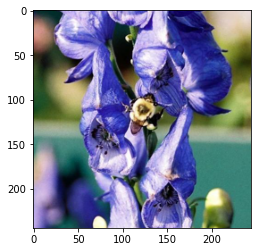

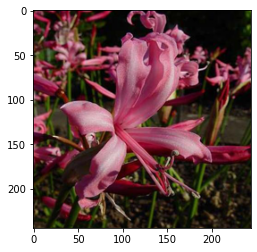

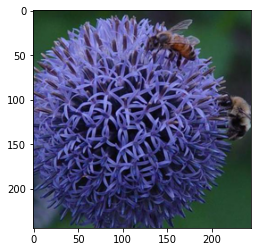

In [11]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    #Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std*image + mean
    
    #Image clipped between 0 and 1
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    
    return ax

imshow(process_image("flowers/test/9/image_06413.jpg"))
imshow(process_image("flowers/test/37/image_03734.jpg"))
imshow(process_image("flowers/test/10/image_07090.jpg"))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [12]:
def predict(image_path, model, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
    image_path: string. Path to image, directly to image and not to folder.
    model: pytorch neural network.
    top_k: integer. The top K classes to be calculated
    
    returns top_probabilities(k), top_labels
    '''
    
    #CPU model
    model.to("cpu")
    
    #Evaluation model
    model.eval();

    #Image from numpy to torch
    torch_image = torch.from_numpy(np.expand_dims(process_image(image_path), axis=0)).type(torch.FloatTensor).to("cpu")

    #Finding probabilities 
    log_probs = model.forward(torch_image)

    #Converting to linear scale
    linear_probs = torch.exp(log_probs)

    #Top 5 results(flowers)
    top_probs, top_labels = linear_probs.topk(top_k)
    
    # Detatch all of the details
    top_probs = np.array(top_probs.detach())[0] 
    top_labels = np.array(top_labels.detach())[0]
    
    #Converting to classes
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labels]
    top_flowers = [cat_to_name[lab] for lab in top_labels]
    
    return top_probs, top_labels, top_flowers

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

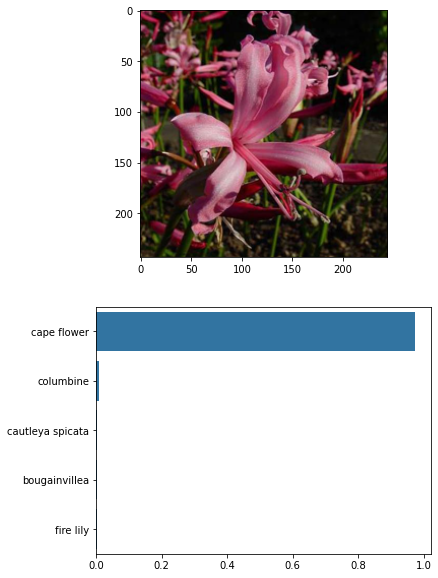

In [13]:
#Image path defined
image_path = "flowers/test/37/image_03734.jpg"

#Making plot ready
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)

#Titles in plot
flower_num = image_path.split('/')[2]
title_ = cat_to_name[flower_num]

#Plotting flower
img = process_image(image_path)
imshow(img, ax, title = title_);

#Prediction
probs, labs, flowers = predict(image_path, model) 

#Bar chart
plt.subplot(2,1,2)
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
plt.show()

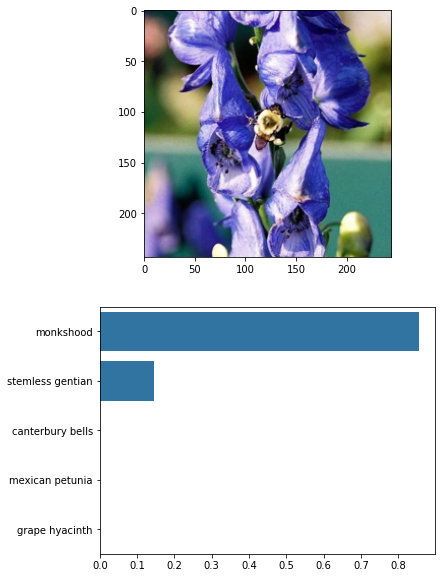

In [14]:
#Picture
image_path = "flowers/test/9/image_06413.jpg"
#Figuresize
plt.figure(figsize = (6,10))
#Top plot
ax = plt.subplot(2,1,1)
flower_num = image_path.split('/')[2]
#Title
title_ = cat_to_name[flower_num]
#Putting in picture
img = process_image(image_path)
imshow(img, ax, title = title_);
probs, labs, flowers = predict(image_path, model) 
#Bottom plot
plt.subplot(2,1,2)
#Barplot in plot 2
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
plt.show()

<font color='red'>**Reminder for Workspace users:** If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.</font>

In [15]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace